# Predictive Modeling

Este notebook é dedicado à modelagem preditiva referente a elaboração de uma estratégia de precificação para uma plataforma de aluguéis temporários na cidade de Nova York. A descrição completa do problema pode ser encontrada em [Descrição.md](Descrição.md).

Explicação da abordagem: serão feitos dois tipos de modelo, um para imóveis de preço normal, outro para imóveis de luxo.

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import tensorflow as tf
import warnings

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

warnings.filterwarnings("ignore", category=FutureWarning)

## Data Preparation

### Removendo colunas que não serão utilizadas

In [88]:
dados = pd.read_csv('teste_indicium_precificacao.csv')

df_1 = dados.copy()
df_1.drop(columns=['id','nome','host_id','host_name','ultima_review','reviews_por_mes','bairro','calculado_host_listings_count'], inplace=True)
df_1.head()

,bairro_group,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,disponibilidade_365
0,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,355
1,Manhattan,40.80902,-73.94190,Private room,150,3,0,365
2,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,194
3,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0
4,Manhattan,40.74767,-73.97500,Entire home/apt,200,3,74,129


### Removendo os Outliers

Um dos problemas a serem enfrentados na remoção de outliers é que esse conjunto de dados têm características muito diferentes para cada tipo de variável, por exemplo, a distribuição dos preços em 'Manhattan' para 'Entire home/apt' é completamente diferente da distribuição para 'Shared room'.

#### Para a variável price

<Axes: >

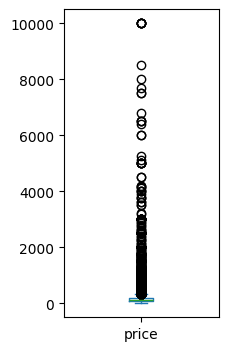

In [89]:
df_1['price'].plot.box(figsize=(2,4))

In [90]:
q1_price, q3_price = df_1['price'].quantile([0.25,0.75])

iqr = q3_price - q1_price

inf = q1_price - 1.5 * iqr
sup = q3_price + 1.5 * iqr

df_1 = df_1[(df_1['price'] >= inf) & (df_1['price'] <= sup)]

<Axes: >

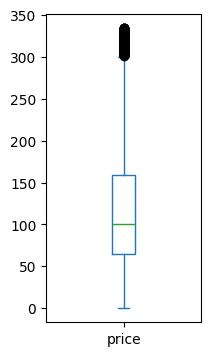

In [91]:
df_1['price'].plot.box(figsize=(2,4))

#### Para a variável minimo_noites

<Axes: >

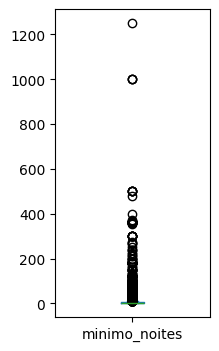

In [92]:
df_1['minimo_noites'].plot.box(figsize=(2,4))

In [93]:
q1_mn, q3_mn = df_1['minimo_noites'].quantile([0.25,0.75])

iqr = q3_mn - q1_mn

inf = q1_mn - 1.5 * iqr
sup = q3_mn + 1.5 * iqr

df_1 = df_1[(df_1['minimo_noites'] >= inf) & (df_1['minimo_noites'] <= sup)]

<Axes: >

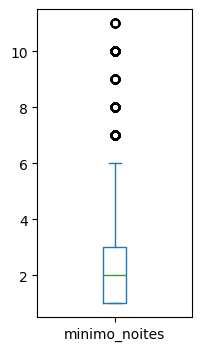

In [94]:
df_1['minimo_noites'].plot.box(figsize=(2,4))

#### Para a variável numero_de_reviews

<Axes: >

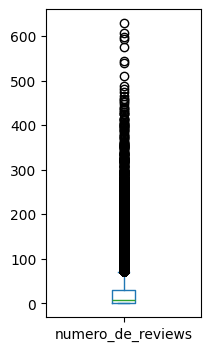

In [95]:
df_1['numero_de_reviews'].plot.box(figsize=(2,4))

In [96]:
q1_nr, q3_nr = df_1['numero_de_reviews'].quantile([0.25,0.75])

iqr = q3_nr - q1_nr

inf = q1_nr - 1.5 * iqr
sup = q3_nr + 1.5 * iqr

df_1 = df_1[(df_1['numero_de_reviews'] >= inf) & (df_1['numero_de_reviews'] <= sup)]

<Axes: >

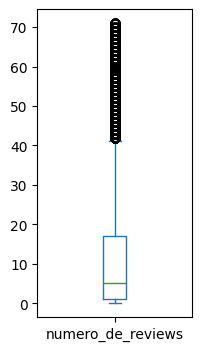

In [97]:
df_1['numero_de_reviews'].plot.box(figsize=(2,4))

### Alterando os tipos das colunas numéricas

In [98]:
df_1.describe().loc[['min', 'max']]

,latitude,longitude,price,minimo_noites,numero_de_reviews,disponibilidade_365
min,40.49979,-74.24442,0.0,1.0,0.0,0.0
max,40.91306,-73.71299,334.0,11.0,71.0,365.0


In [99]:
df_1['price'] = df_1['price'].astype(np.uint16)
df_1['minimo_noites'] = df_1['minimo_noites'].astype(np.uint8)
df_1['numero_de_reviews'] = df_1['numero_de_reviews'].astype(np.uint8)
df_1['disponibilidade_365'] = df_1['disponibilidade_365'].astype(np.uint16)
df_1['latitude'] = df_1['latitude'].astype(np.float32)
df_1['longitude'] = df_1['longitude'].astype(np.float32)

### Scaling das Variáveis Numéricas

In [100]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35201 entries, 0 to 48893
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bairro_group         35201 non-null  object 
 1   latitude             35201 non-null  float32
 2   longitude            35201 non-null  float32
 3   room_type            35201 non-null  object 
 4   price                35201 non-null  uint16 
 5   minimo_noites        35201 non-null  uint8  
 6   numero_de_reviews    35201 non-null  uint8  
 7   disponibilidade_365  35201 non-null  uint16 
dtypes: float32(2), object(2), uint16(2), uint8(2)
memory usage: 1.3+ MB


### Enconding das Variáveis Categóricas

In [101]:
df_1 = pd.concat((df_1, pd.get_dummies(df_1['room_type'], dtype=int), pd.get_dummies(df_1['bairro_group'], dtype=np.uint8)), axis=1).drop(columns=['room_type','bairro_group'])

In [102]:
df_1.head()

,latitude,longitude,price,minimo_noites,numero_de_reviews,disponibilidade_365,Entire home/apt,Private room,Shared room,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,40.753620,-73.983772,225,1,45,355,1,0,0,0,0,1,0,0
1,40.809021,-73.941902,150,3,0,365,0,1,0,0,0,1,0,0
3,40.798512,-73.943993,80,10,9,0,1,0,0,0,0,1,0,0
9,40.803162,-73.965446,135,5,53,6,1,0,0,0,0,1,0,0
17,40.675919,-73.946938,99,3,53,21,1,0,0,0,1,0,0,0


In [103]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35201 entries, 0 to 48893
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   latitude             35201 non-null  float32
 1   longitude            35201 non-null  float32
 2   price                35201 non-null  uint16 
 3   minimo_noites        35201 non-null  uint8  
 4   numero_de_reviews    35201 non-null  uint8  
 5   disponibilidade_365  35201 non-null  uint16 
 6   Entire home/apt      35201 non-null  int64  
 7   Private room         35201 non-null  int64  
 8   Shared room          35201 non-null  int64  
 9   Bronx                35201 non-null  uint8  
 10  Brooklyn             35201 non-null  uint8  
 11  Manhattan            35201 non-null  uint8  
 12  Queens               35201 non-null  uint8  
 13  Staten Island        35201 non-null  uint8  
dtypes: float32(2), int64(3), uint16(2), uint8(7)
memory usage: 1.7 MB


### Splitting Data 

In [104]:
X = df_1.drop(columns=['price']).values
y = df_1['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
scaler = sk.preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modeling + Cross Validation

In [118]:
def evaluate_model(model, X, y, model_name, func_model=None, n_splits=5, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    results = {
        "fold": [],
        "rmse": [],
        "mae": [],
        "r2": []
    }
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"Fold {fold + 1}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        if(model_name == 'Neural Network'):
            model = func_model()
            history = model.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_val, y_val), verbose=0)

            fig, ax = plt.subplots(1,2,figsize=(14, 4))
            ax[0].plot(history.history['loss'], label='Train Loss')
            ax[0].plot(history.history['val_loss'], label='Validation Loss')
            ax[1].plot(history.history['r2_score'], label='Train r2_score')
            ax[1].plot(history.history['val_r2_score'], label='Validation r2_score')
            plt.legend()
            plt.show()

        else:
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        
        rmse = root_mean_squared_error(y_val, y_pred)
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        
        results["fold"].append(fold + 1)
        results["rmse"].append(rmse)
        results["mae"].append(mae)
        results["r2"].append(r2)
        
        print(f" RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    results = pd.DataFrame(results).mean().to_dict()
    results['Model Name'] = model_name
    
    return results


In [107]:
Gradient_Boost = GradientBoostingRegressor()

res_gradient_boost = evaluate_model(Gradient_Boost, X_train, y_train, 'Gradient Boost')

Fold 1


 RMSE: 45.0942, MAE: 32.7749, R2: 0.5600
Fold 2
 RMSE: 45.5509, MAE: 33.4225, R2: 0.5343
Fold 3
 RMSE: 46.2291, MAE: 33.4165, R2: 0.5472
Fold 4
 RMSE: 46.2785, MAE: 33.3616, R2: 0.5310
Fold 5
 RMSE: 45.1863, MAE: 33.0400, R2: 0.5518


In [108]:
XG_Boost = XGBRegressor()

res_xg_boost = evaluate_model(XG_Boost, X_train, y_train, 'XG Boost')

Fold 1
 RMSE: 45.9266, MAE: 33.2309, R2: 0.5436
Fold 2
 RMSE: 46.1680, MAE: 33.7581, R2: 0.5215
Fold 3
 RMSE: 46.3440, MAE: 33.3782, R2: 0.5450
Fold 4
 RMSE: 46.7351, MAE: 33.6347, R2: 0.5217
Fold 5
 RMSE: 45.2428, MAE: 32.9555, R2: 0.5507


In [109]:
Light_GBM = LGBMRegressor(force_row_wise=True, verbose=-1)

res_lightgbm = evaluate_model(Light_GBM, X_train, y_train, 'Light_GBM')

Fold 1
 RMSE: 44.9500, MAE: 32.4579, R2: 0.5628
Fold 2
 RMSE: 45.1243, MAE: 33.0252, R2: 0.5429
Fold 3
 RMSE: 45.6321, MAE: 32.8604, R2: 0.5589
Fold 4
 RMSE: 45.8761, MAE: 32.9707, R2: 0.5391
Fold 5
 RMSE: 44.5951, MAE: 32.4990, R2: 0.5635


In [110]:
Random_Forest = RandomForestRegressor(random_state=42)

res_random_forest = evaluate_model(Random_Forest, X_train, y_train, 'Random Forest')

Fold 1
 RMSE: 46.1433, MAE: 33.5155, R2: 0.5393
Fold 2
 RMSE: 46.2406, MAE: 33.8266, R2: 0.5200
Fold 3
 RMSE: 46.4258, MAE: 33.5106, R2: 0.5434
Fold 4
 RMSE: 47.0766, MAE: 34.0576, R2: 0.5146
Fold 5
 RMSE: 45.3618, MAE: 33.0624, R2: 0.5483


In [111]:
Logistic_Regr = LogisticRegression(C=0.1)

res_Logistic_Regr = evaluate_model(Logistic_Regr, X_train, y_train, 'Logistic Regression')

Fold 1
 RMSE: 52.1340, MAE: 37.3855, R2: 0.4119
Fold 2
 RMSE: 50.8885, MAE: 36.3436, R2: 0.4187
Fold 3
 RMSE: 53.2593, MAE: 38.1298, R2: 0.3991
Fold 4
 RMSE: 52.6050, MAE: 37.5396, R2: 0.3940
Fold 5
 RMSE: 51.9260, MAE: 37.1942, R2: 0.4081


Fold 1


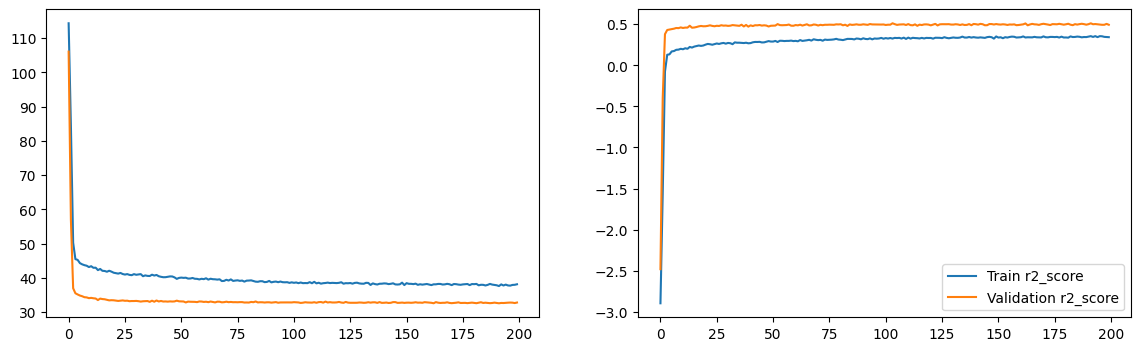

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
 RMSE: 48.3600, MAE: 33.3053, R2: 0.4939
Fold 2


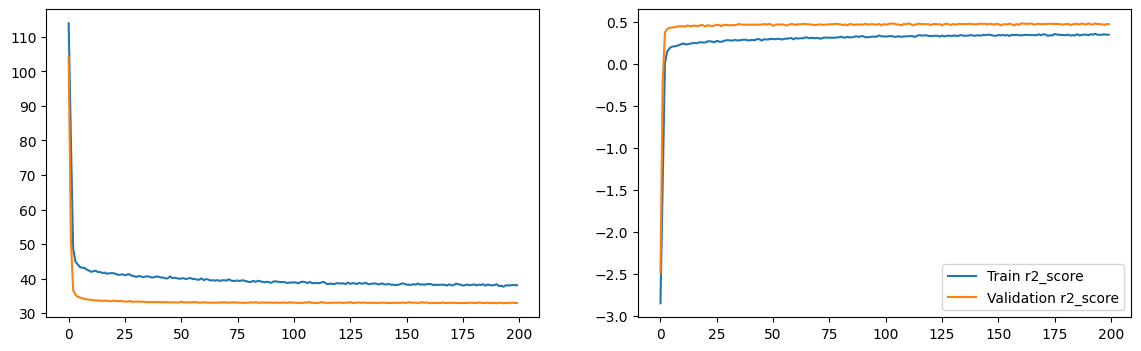

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 RMSE: 48.3578, MAE: 33.4429, R2: 0.4751
Fold 3


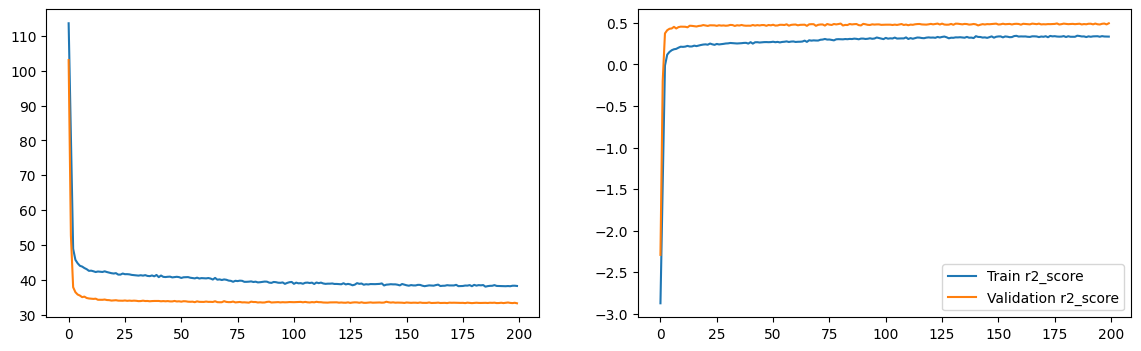

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 RMSE: 48.8062, MAE: 33.7225, R2: 0.4954
Fold 4


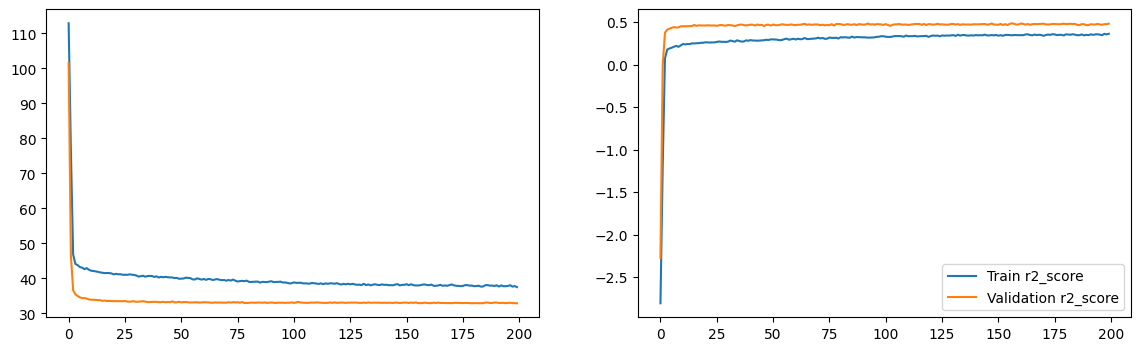

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 RMSE: 48.6208, MAE: 33.4073, R2: 0.4823
Fold 5


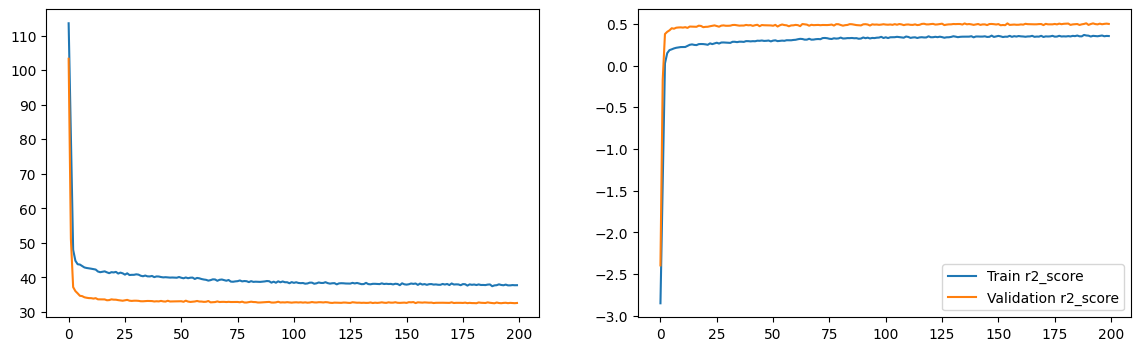

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 RMSE: 47.7955, MAE: 33.1089, R2: 0.4985


In [ ]:
def create_model():
    Neural_Network = Sequential()

    Neural_Network.add(Input(shape=(X_train.shape[1],)))
    Neural_Network.add(Dense(32, activation='relu'))
    Neural_Network.add(Dropout(0.5))
    Neural_Network.add(Dense(32, activation='relu'))
    Neural_Network.add(Dropout(0.5))
    Neural_Network.add(Dense(1, activation='linear'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss_func = tf.keras.losses.Huber()

    mae = tf.keras.metrics.MeanAbsoluteError()
    rmse = tf.keras.metrics.RootMeanSquaredError()
    r2 = tf.keras.metrics.R2Score()

    Neural_Network.compile(optimizer=optimizer, loss=loss_func, metrics=[mae, rmse, r2])

    return Neural_Network


res_Neural_Network = evaluate_model(None, X_train, y_train, 'Neural Network', create_model)

In [126]:
df_results = pd.DataFrame([res_gradient_boost, res_xg_boost, res_lightgbm, res_random_forest, res_Logistic_Regr, res_Neural_Network]).drop(columns=['fold'])
df_results = df_results.reindex(['Model Name', 'rmse', 'mae', 'r2'], axis=1)

In [127]:
df_results.sort_values(by='rmse', ascending=True)

,Model Name,rmse,mae,r2
2,Light_GBM,45.235530,32.762662,0.553424
0,Gradient Boost,45.667776,33.203094,0.544848
1,XG Boost,46.083307,33.391468,0.536492
3,Random Forest,46.249594,33.594526,0.533130
5,Neural Network,48.388055,33.397370,0.489041
4,Logistic Regression,52.162560,37.318537,0.406346
